In [106]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import calendar
import datetime
from time import strftime
from datetime import datetime
import seaborn as sns
ids = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-k-volkov-23/2_data/8.1_olist_customers_dataset.csv')
orders = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-k-volkov-23/2_data/8.2_olist_orders_dataset.csv', 
                     parse_dates=['order_purchase_timestamp', 
                                  'order_approved_at', 
                                  'order_delivered_carrier_date', 
                                  'order_delivered_customer_date', 
                                  'order_estimated_delivery_date'])
items = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-k-volkov-23/2_data/8.3_olist_order_items_dataset.csv')

In [107]:
# Первое задание, замерджил датафреймы с номерами пользователей и заказами в ответе получено, что у нас 96096 из 99441 клиентов купили что-то только один раз.
# Ответ:  доля пользователей которые сделали только один заказ составляет 96.63 %.
ids_orders = pd.merge(ids, orders, how='inner')
ids_orders.customer_unique_id.nunique() / len(ids_orders) * 100

96.63619633752677

In [108]:
#2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?
# Для выплнения этого задания лучше взять даты совершения заказов и посмотреть на их статус.
# Среди всех статусов к не доставленным можно отнести "canceled" и "unavailable"
# Если с "canceled" все понятно, клиент его просто отменил.
# То во втором случае не ясно, что произошло с заказом, предполагаю, что оно не отслеживается или не пришло в пункт выдачи.
# Получается мы имеем 625 отмененных заказов и 609 не отслеживаемых, сгруппировал по месяцам. 
ids_orders['month_of_purchase'] = ids_orders['order_purchase_timestamp'].dt.to_period('M')
not_shipped = ids_orders.query('order_status == "canceled" or order_status == "unavailable"')\
        .groupby(['order_status', 'month_of_purchase'], as_index=False)\
        .agg({'customer_id': 'count'})\
        .sort_values(by='customer_id', ascending=False)
# Таким образом получается, что у нас в среднем за месяц не доезжает по 27 заказов
not_shipped.mean()

customer_id    27.422222
dtype: float64

In [109]:
# 3. По каждому товару определить, в какой день недели товар чаще всего покупается. (5 баллов)
# Чтобы выполник след задачу нужно замерджить заказы и товары
# Уберем дупликаты из items
items = items.drop_duplicates(subset=['order_id'])
# Добавить дни недели в отдельный столбец, вытащить из даты заказы.
orders_items = pd.merge(orders, items, how='inner')
orders_items['dw'] = orders_items['order_approved_at'].dt.day_name()

# Группирую наши товары по дням недели, сортирую по убыванию, результыт меня удовлетворяет

top_dw_item = orders_items.groupby(['product_id','dw'], as_index=False)\
        .agg({'customer_id': 'count'}).sort_values(by='customer_id', ascending=False)

#переменовал для наглядности колонку с нужными нам покупателями

top_dw_item.rename(columns = {'customer_id':'orders'}, inplace = True)
#в итоге выведен список с  самыми провадавемыми большими продажами каждого товара по дням недели
top_dw_item.head(10)

,product_id,dw,orders
19455,53b36df67ebb7c41585e8d54d6772e08,Tuesday,96
39661,aca2eb7d00ea1a7b8ebd4e68314663af,Tuesday,96
39656,aca2eb7d00ea1a7b8ebd4e68314663af,Friday,77
35310,99a4788cb24856965c36a24e339b6058,Tuesday,75
39662,aca2eb7d00ea1a7b8ebd4e68314663af,Wednesday,73
15400,422879e10f46682990de24d770e7f83d,Tuesday,68
35306,99a4788cb24856965c36a24e339b6058,Monday,66
35307,99a4788cb24856965c36a24e339b6058,Saturday,64
35311,99a4788cb24856965c36a24e339b6058,Wednesday,64
35305,99a4788cb24856965c36a24e339b6058,Friday,63


In [110]:
# Выводится сводная таблица с заказами по дням, в ней можно посмотреть как товары продаютс по дням недели,
# Ее смысл заключается в том, что  в ней мы можем проверить день на одинаковое количество заказов.
top_dw_item.pivot(index='product_id', columns='dw', values='orders').fillna(0).sort_values(by='Tuesday', ascending=False).head(5)

dw,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
product_id,,,,,,,
aca2eb7d00ea1a7b8ebd4e68314663af,77.0,42.0,48.0,33.0,60.0,96.0,73.0
53b36df67ebb7c41585e8d54d6772e08,37.0,29.0,25.0,15.0,49.0,96.0,51.0
99a4788cb24856965c36a24e339b6058,63.0,66.0,64.0,46.0,61.0,75.0,64.0
422879e10f46682990de24d770e7f83d,55.0,30.0,49.0,29.0,56.0,68.0,53.0
d1c427060a0f73f6b889a5c7c61f2ac4,42.0,45.0,49.0,26.0,49.0,60.0,47.0


In [111]:
# 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)?
# Не стоит забывать, что внутри месяца может быть не целое количество недель.
# Например, в ноябре 2021 года 4,28 недели.
# И внутри метрики это нужно учесть. (8 баллов)

#самое время замерждить весь датасет, только оказалось
data = pd.merge(ids_orders, items, how='inner')
#теперь стоит строить данные основываясь на дате доспавке, т.к. здесь мы уже рассматриваем покупку товара а не заказ.
data['month_of_order'] = ids_orders['order_approved_at'].dt.to_period('M')

#необходимо достать количество недель внутри месяца и добавить в датафрейм для последующих расчетов 
data['number_of_weeks'] = data['month_of_order'].dt.days_in_month / 7
#теперь производим нужные группировки
mean_orders = data.groupby(['customer_unique_id', 'product_id', 'month_of_purchase'], as_index=False)\
    .agg({'product_id': 'count'}).sort_values(by='product_id', ascending=False)
# осталось добавить столбец со средним количеством заказов в месяц, поделив количество заказов в месяц на кол-во недель
mean_orders['mean_orders'] = mean_orders.product_id.divide(other=data.number_of_weeks)
mean_orders

,customer_unique_id,month_of_purchase,product_id,mean_orders
77157,c8460e4251689ba205045f3ea17884a1,2018-08,4,0.933333
71869,ba87a137c5191264841e0be40e53f4ed,2018-02,3,0.700000
14653,25f3cf83109f636d52d288fa4e797111,2018-02,3,0.677419
27184,46958f708ade6b6a88b2e5aca1e66de5,2017-08,3,0.677419
72174,bb58670190dba4e9b320f84cb98317a3,2017-06,3,0.700000
...,...,...,...,...
32852,5540a5059478be29d0280d0c8c01345c,2017-12,1,0.225806
32851,553f3ea5d1e743cd91146d3d06e944f0,2018-08,1,0.233333
32850,553e50a6e4eede20b2319c85a0584398,2018-02,1,0.233333
32849,553e08d19f15562d267d0e551cbab2d0,2017-06,1,0.233333


In [112]:
# 5. Используя pandas, проведи когортный анализ пользователей 
# В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц
#то что требуется для построения когортного анализа
ww = data[['customer_unique_id', 'month_of_order', 'order_approved_at']]
#убрал день и время
#ww['month_of_order'] = ww['month_of_order'].dt.to_period('M')
# отфильтровал год
ww = ww.query('month_of_order >= "2017-01" and month_of_order <= "2017-12"')

In [113]:
#заказы каждого пользователя по месяцам
ww = ww.groupby(['customer_unique_id', 'month_of_order'], as_index=False)\
    .agg({'order_approved_at': 'count'}).sort_values(by='order_approved_at', ascending=False)


In [114]:
ww.rename(columns = {'order_approved_at':'orders'}, inplace = True)

In [115]:
# убираем там где не было подтвержденных заказов
ww = ww.query('orders > 0')

In [116]:
# данные с первыми появлениями наших клиентов.
# их надо будет примерджить 
first_event = ww.groupby(by=['customer_unique_id'], as_index=False).min().reset_index()
first_event.rename(columns = {'month_of_order':'first_event'}, inplace = True)
first_event = first_event[['customer_unique_id', 'first_event']]
first_event

,customer_unique_id,first_event
0,0000b849f77a49e4a4ce2b2a4ca5be3f,2017-03
1,0000f46a3911fa3c0805444483337064,2017-12
2,0004aac84e0df4da2b147fca70cf8255,2017-07
3,0005e1862207bf6ccc02e4228effd9a0,2017-08
4,00082cbe03e478190aadbea78542e933,2017-08
...,...,...
43929,fff96bc586f78b1f070da28c4977e810,2017-05
43930,fffa431dd3fcdefea4b1777d114144f2,2017-12
43931,fffea47cd6d3cc0a88bd621562a9d061,2017-05
43932,ffff5962728ec6157033ef9805bacc48,2017-02


In [117]:
#примердить даты первого заказа
ww = pd.merge(ww, first_event, how='inner')

In [118]:
#чтобы посчитать разницу между месяцами привел в нужный тип данных
ww['month_of_order'] = ww['month_of_order'].astype(str)
ww['month_of_order'] = pd.to_datetime(ww['month_of_order'])
ww['first_event'] = ww['first_event'].astype(str)
ww['first_event'] = pd.to_datetime(ww['first_event'])

ww.dtypes

customer_unique_id            object
month_of_order        datetime64[ns]
orders                         int64
first_event           datetime64[ns]
dtype: object

In [119]:
#вВременной интервал, по которому будет строиться когорта: каждый третий месяц !
ww['seniority'] = ((ww.month_of_order - ww.first_event) / np. timedelta64(1, 'M'))

In [120]:
ww['seniority'] = ww['seniority'].round()

In [121]:
ww['seniority'] = ww['seniority'].astype(int)
ww['seniority'] = ww['seniority'] + 1
ww

,customer_unique_id,month_of_order,orders,first_event,seniority
0,3bab949ef05da8e9b3cfd541b6af0ffd,2017-11-01,2,2017-10-01,2
1,3bab949ef05da8e9b3cfd541b6af0ffd,2017-10-01,1,2017-10-01,1
2,711066a7bba9951b1da0ce0f4302af23,2017-11-01,2,2017-11-01,1
3,30b782a79466007756f170cb5bd6bbd8,2017-12-01,2,2017-12-01,1
4,5e8f38a9a1c023f3db718edcf926a2db,2017-11-01,2,2017-07-01,5
...,...,...,...,...,...
44542,551d7e7f909ea5c58235d9ab0d6e719c,2017-03-01,1,2017-03-01,1
44543,551e541ae4351dbd9f96875b089c2c1b,2017-07-01,1,2017-07-01,1
44544,551f26c6693657b95e4b6050af3cad95,2017-07-01,1,2017-07-01,1
44545,551f97f309e80f9b2c330d7b90e500fa,2017-12-01,1,2017-12-01,1


In [122]:
# сгруппировать данные для когортного анализа
group = ww.groupby(['first_event', 'seniority'])

cohort_data = group['customer_unique_id'].count()

cohort_data = cohort_data.reset_index()
cohort_data.head(5)

,first_event,seniority,customer_unique_id
0,2017-01-01,1,754
1,2017-01-01,5,1
2,2017-01-01,6,3
3,2017-01-01,7,3
4,2017-01-01,8,1


In [123]:
# сделать таблицу когорт
cohort_counts = cohort_data.pivot(index='first_event', columns='seniority', values='customer_unique_id')

# делаем знаменатель для нашего retention
base = cohort_counts[1]

# Теперь формула для retention
retention = cohort_counts.divide(base, axis=0).round(3)

In [124]:
# самый большой reteintion на тетий месяц у пользователей сделавших заказ 2017-09-01, пол процента, не густо конечно
# Хит меп с процентами выводить нет смысла, будут одни нули...
# внесли свои изменения дупликаты в датафрейме с товарными позициями, после того как пофиксил появились NaN'ы
retention

seniority,1,2,3,4,5,6,7,8,9,10,11,12
first_event,,,,,,,,,,,,
2017-01-01,1.0,NaN,NaN,NaN,0.001,0.004,0.004,0.001,0.001,0.001,0.007,0.003
2017-02-01,1.0,0.002,0.002,0.002,NaN,0.003,0.004,0.003,0.001,0.005,0.004,NaN
2017-03-01,1.0,0.002,0.003,0.003,0.003,0.003,0.004,0.006,0.005,0.004,NaN,NaN
2017-04-01,1.0,0.002,0.001,0.003,0.004,0.003,0.003,0.005,0.004,NaN,NaN,NaN
2017-05-01,1.0,0.002,0.002,0.004,0.002,0.005,0.005,0.006,NaN,NaN,NaN,NaN
2017-06-01,1.0,0.002,0.003,0.004,0.002,0.008,0.003,NaN,NaN,NaN,NaN,NaN
2017-07-01,1.0,0.005,0.002,0.005,0.006,0.003,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-01,1.0,0.002,0.003,0.008,0.003,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-01,1.0,0.002,0.005,0.003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [125]:
#  6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. 
# Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. 
# В кластеризации можешь выбрать следующие метрики: 
#     R - время от последней покупки пользователя до текущей даты, 
#     F - суммарное количество покупок у пользователя за всё время, 
#     M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. 
# Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. 
# Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, 
# frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю.

In [126]:
#возьмем нужные колонки
t = data[['order_id', 'customer_unique_id', 'order_approved_at', 'product_id', 'price']]
# уберем повторяющиеся дупликаты
#t = t.drop_duplicates(subset=['order_id'])

In [127]:
t = t.rename(columns = {'customer_unique_id':'CustomerID', 'order_approved_at': 'date_of_order'})

In [128]:
#добавить колонку с суммой потраченых денег
rev = t.groupby(['CustomerID'], as_index=False).agg({'price': 'sum'}).sort_values(by='price', ascending=False)
rev = rev.rename(columns = {'price':'monetary'})
t = pd.merge(t, rev)

In [129]:
#судя по данным у нас есть киты
t.sort_values(by='monetary', ascending=False).head(5)

,order_id,CustomerID,date_of_order,product_id,price,monetary
28487,8ea7aebc18842332aad5f41ca74b334c,da122df9eeddfedc1dc1f5349a1a690c,2017-04-03 13:25:19,3ecf69ee1fe21cfd40b30cbea549e563,2589.0,7388.0
28486,a96610ab360d42a2e5335a3998b4718a,da122df9eeddfedc1dc1f5349a1a690c,2017-04-03 13:25:18,a6492cc69376c469ab6f61d8f44de961,4799.0,7388.0
14189,0812eb902a67711a1cb742b3cdaa65ae,dc4802a71eae9be1dd28f5d788ceb526,2017-02-12 20:45:12,489ae2aa008f021502940f251d4cce7f,6735.0,6735.0
22227,fefacc66af859508bf1a7934eab1e97f,459bef486812aa25204be022145caa62,2018-07-27 04:05:13,69c590f7ffc7bf8db97190b6cb6ed62e,6729.0,6729.0
4170,f5136e38d1a14a4dbd87dff67da82701,ff4159b92c40ebe40454e3e6a7c35ed6,2017-05-26 02:45:17,1bdf5e6731585cf01aa8169c7028d6ad,6499.0,6499.0


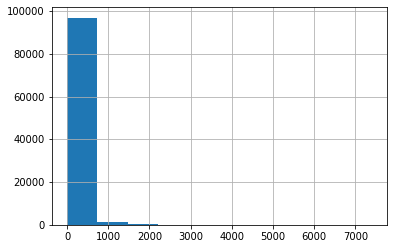

In [130]:
# большинство заказов с чеком меньше 1000
t['monetary'].hist()

In [131]:
t['today_day'] = '2018-09-04' 

In [132]:
t['today_day'] = pd.to_datetime(t['today_day'])

In [133]:
# первый заказ
tt = t.groupby(['CustomerID'], as_index=False).agg({'date_of_order': 'min'})
tt = tt.rename(columns = {'date_of_order':'first_event'})

In [134]:
# последний заказ
ttt = t.groupby(['CustomerID'], as_index=False).agg({'date_of_order': 'max'})
ttt = ttt.rename(columns = {'date_of_order':'last_purchase'})

In [135]:
t = pd.merge(t, tt)
t = pd.merge(t, ttt)

In [136]:
t['recency'] = ((t.today_day - t.last_purchase) / np. timedelta64(1, 'D'))

In [137]:
# теперь можно найти сумму заказов через номер чека (идентификатор заказа)
frequency = t.groupby(['CustomerID'], as_index=False).agg({'order_id': 'count'}).sort_values(by='order_id', ascending=False)
frequency = frequency.rename(columns = {'order_id':'frequency'})

In [138]:
t = pd.merge(t, frequency, how='inner')


In [139]:
rfm = t[['CustomerID', 'first_event', 'last_purchase', 'recency', 'frequency', 'monetary']]

In [140]:
# данный кластер слаю с помощью функции qcut, просто разделив количество дней на процентили, по 33% соответственно.
# recency имеет границы: 1 - от 294 до 718
#                        2 - от 153 до 294
#                        3 - от 0   до 153
rfm['r'] = 4 - (pd.qcut(rfm['recency'], 3, labels=False) + 1)

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [141]:
# единственный способ по которому получилось создать кластеры.
# frequency имеет границы: 1 - от 1 до 2
#                          2 - от 3 до 9
#                          3 - от 10 и больше
conditions = [
    (rfm['frequency'] <= 2),
    (rfm['frequency'] > 2) & (rfm['frequency'] <= 9),
    (rfm['frequency'] > 9)]
values = ['1', '2', '3']
rfm['f'] = np.select(conditions, values)
rfm['f'] = rfm['f'].astype(int)

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [142]:
# frequency имеет границы: 1 - от 0 до 199
#                          2 - от 200 до 2999
#                          3 - от 3000 и больше
def get_m(x):
    if x < 200:
        return 1
    if x >= 200 and x <3000:
        return 2
    if x >= 3000:
        return 3
rfm['m'] = rfm['monetary'].apply(get_m)

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [143]:
# теперь можно посчитать самых лоялных клиентов
rfm['score'] = ((rfm['r'] + rfm['f'] + rfm['m']) / 3).round(2)

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [144]:
# отфильтровано, взяты интересующие нас ячейки по каждому клиенту, теперь можно делать выводы.
rfm_score = rfm[['CustomerID', 'recency', 'frequency', 'monetary', 'r', 'f', 'm', 'score']]
rfm_score = rfm_score.drop_duplicates(subset=['CustomerID'])

In [145]:
#итоговая таблица
rfm_score.sort_values(by='score', ascending=False).head(50)

,CustomerID,recency,frequency,monetary,r,f,m,score
14960,8d50f5eadf50201ccdcedfb9e2ac8455,14.187442,16,729.62,3.0,3,2,2.67
90000,ca27f3dac28fb1063faddd424c9d95fa,35.656088,1,4059.00,3.0,1,3,2.33
13778,56c8638e7c058b98aae6d74d2dd6ea23,137.200787,5,464.18,3.0,2,2,2.33
22330,12d8b5ed661190a3a08183644dfc504d,124.489711,4,569.60,3.0,2,2,2.33
26491,a0abd26659c9914690cbd3320d39fd96,72.503056,4,307.29,3.0,2,2,2.33
3208,d132b863416f85f2abb1a988ca05dd12,44.159491,3,690.91,3.0,2,2,2.33
18368,91d0504cf52d3f76b154c42d78979f39,83.281921,3,201.70,3.0,2,2,2.33
34129,f8bc1d81f395f6239a2a5ab1b9edf1ab,14.350174,3,217.79,3.0,2,2,2.33
1173,b896655e2083a1d76b7b85df8fc86e40,58.799745,4,439.40,3.0,2,2,2.33
7697,a029899dd8534557a81c369475ff80c8,123.824444,3,212.80,3.0,2,2,2.33


In [ ]:
# recency имеет границы: 1 - от 294 до 718
#                        2 - от 153 до 294
#                        3 - от 0   до 153

# frequency имеет границы: 1 - от 1 до 2
#                          2 - от 3 до 9
#                          3 - от 10 и больше

# frequency имеет границы: 1 - от 0 до 199
#                          2 - от 200 до 2999
#                          3 - от 3000 и больше

In [ ]:
# метод для проверки границ
# rfm.groupby('m')['monetary'].agg(['mean', 'count'])

# посмотреть гистограмму
# rfm[rfm['monetary']>400]['monetary'].hist()

# еще один метор посмотреть на границы
# rfm.groupby('m')['monetary'].agg(set)